# Pyspark Transformers

In this notebook, we'll work through the construction of our own Transformer in Pyspark. Transformers act on an input dataframe to yield a modified version of the same dataframe. They form a key component to pipelines, where a series of transformers can be chained together to perform all the required data processing. 

The aim of this pipeline will be to make use of a Decision Tree Regressor to predict housing values. We will make use of the **California Housing Prices** dataset. These data were briefly explored in Notebook XXVI, and as such I won't repeat that analysis here.

We can start by importing the necessary packages, and setting up our spark session:

In [1]:
import findspark
findspark.init("/opt/homebrew/Cellar/apache-spark/3.5.0/libexec")

In [ ]:
from sklearn.datasets import fetch_california_housing
from typing import Any
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark import keyword_only
from pyspark.sql import functions as F
from pyspark.sql import dataframe as DataFrame
from pyspark.ml import Transformer, Pipeline 
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.param.shared import HasInputCols, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
spark = SparkSession.builder.appName("test").getOrCreate()

## Dataset

Now let's obtain the data we will work with. A description of the data can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing

In [3]:
# obtain data
data = fetch_california_housing(as_frame=True)
dfX = data["data"]
sY = data["target"]

In [4]:
dfX.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Since I'll be using a Decision Tree to model these data, the preprocessing work we'll have to do is minimal. Nonetheless, here we will focus on the Latitude and Longitude columns, and attempt to convert these values into categories based on their rough groupings. Our custom Transformer will aim to do just that.

First let's take a peek to see what our distribution of Latitude and Longitude looks like:

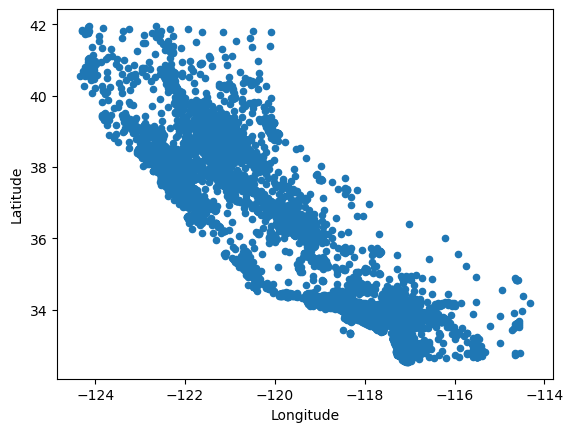

In [5]:
dfX.plot.scatter(x='Longitude',y='Latitude')
plt.show()

We can make out the rough shape of California in this plot. It is evident that the distribution is grouped at various points on the map. Normally, we would assign labels to these groupings through some data-driven technique (e.g. KMeans). However, for the purpose of this demonstration I will build a simple Transformer to handle this task. The Transformer will partition the data based upon very simple hand-written rules. The figure below illustrates how labels will be assigned based on geographical location:

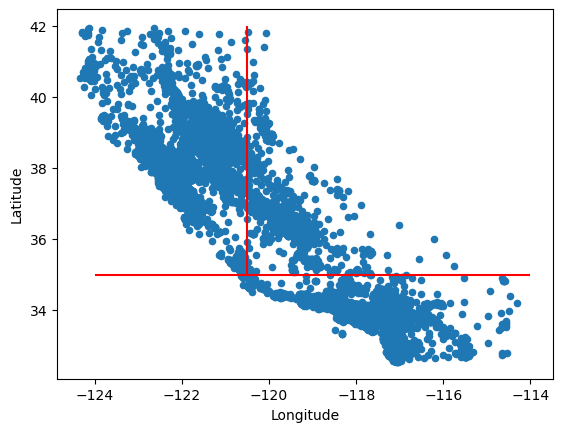

In [6]:
dfX.plot.scatter(x='Longitude',y='Latitude')
plt.hlines(y=35, xmin=-124, xmax=-114, color='red')
plt.vlines(x=-120.5, ymin=35, ymax=42, color='red')
plt.show()

The Latitude and Longitude points in the data will be split into 3 groups. These are labelled as: 
1. South
2. North
3. Interior

All points at or below Latitude 35 will be assigned to group 1 (South). All points above Latitude 35, and less than or equal to Longitude -120.5 we be assigned to group 2 (North). All remaining points are given to group 3 (Interior).

Before proceeding, let's place our data into a pyspark dataframe:

In [7]:
dfX["MedHouseVal"] = sY
df = spark.createDataFrame(dfX)
df.show(5)

+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|MedInc|HouseAge|          AveRooms|         AveBedrms|Population|          AveOccup|Latitude|Longitude|MedHouseVal|
+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|8.3252|    41.0| 6.984126984126984|1.0238095238095237|     322.0|2.5555555555555554|   37.88|  -122.23|      4.526|
|8.3014|    21.0| 6.238137082601054|0.9718804920913884|    2401.0| 2.109841827768014|   37.86|  -122.22|      3.585|
|7.2574|    52.0| 8.288135593220339| 1.073446327683616|     496.0|2.8022598870056497|   37.85|  -122.24|      3.521|
|5.6431|    52.0|5.8173515981735155|1.0730593607305936|     558.0| 2.547945205479452|   37.85|  -122.25|      3.413|
|3.8462|    52.0| 6.281853281853282|1.0810810810810811|     565.0|2.1814671814671813|   37.85|  -122.25|      3.422|
+------+--------+------------------+------------------+---------

## Custom Transformer

Now that we know what needs to be done, let's build a new transformer *AssignRegion*:

In [8]:
class AssignRegion(Transformer, HasInputCols, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    """
    Class to convert latitude and longitude into a geographical region within California (either 1, 2, or 3)
    """
    verbose = Param(
        Params._dummy(),
        "verbose",
        "Boolean to determine if transformer prints out status when running.",
        typeConverter=TypeConverters.toBoolean,
    )
    
    @keyword_only
    def __init__(self,
                 inputCols: list=[],
                 outputCol: str='',
                 verbose: bool=False) -> None:
        """
        Function to initialise the class instance
        """
        super().__init__()
        self._setDefault(inputCols=[], outputCol='', verbose=False)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)

    @keyword_only
    def set_params(self,
                   inputCols: list=[],
                   outputCol: str='',
                   verbose: bool=False) -> None:
        kwargs = self._input_kwargs
        self._set(**kwargs)

    def setVerbose(self, new_verbose: bool) -> Any:
        return self.setParams(verbose=new_verbose)

    def getVerbose(self) -> bool:
        return self.getOrDefault(self.verbose)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Function to determine the region based off of the latitude and longitude values
        """
        # read in the transformer parameters
        inputCols = self.getInputCols()
        outputCol = self.getOutputCol()
        verbose = self.getVerbose()

        # return the dataframe with geographical regions included
        try:
            df = df.withColumn(outputCol, 
                               F.when( F.col(inputCols[0]) <= 35, 1 )
                               .when( (F.col(inputCols[0]) > 35) & (F.col(inputCols[1]) <= -120.5), 2 )
                               .otherwise(3)
                              )
            if verbose:
                print("Our transformer works!")
        except Exception as e:
            if verbose:
                print(f"Something went wrong, {e}")
            pass
        return df

We can now test out our transformer to verify that it works:

In [9]:
t = AssignRegion(inputCols=['Latitude','Longitude'], outputCol='Region', verbose=True)

In [10]:
df = t.transform(df)

Our transformer works!


In [11]:
df.groupby('Region').count().show()

+------+-----+
|Region|count|
+------+-----+
|     3| 1604|
|     2| 7742|
|     1|11294|
+------+-----+



Our simple transformer appears to be working with our data.

## Using our Transformer in a Pipeline

The strength of writing our own Transformers comes when applying them within a machine learning pipeline. Here we'll now incorporate the class we wrote above into a pipeline for modelling our data.

In [12]:
# split the data into training and test sets
n_count = df.count()
dfTrain = df.limit(int(n_count*0.8))
dfTest  = df.subtract(dfTrain)

In [13]:
# define the pipeline
cols = dfTrain.columns
cols.remove('MedHouseVal')
cols.remove('Latitude')
cols.remove('Longitude')
pipeline = Pipeline(stages=[
    AssignRegion(inputCols=['Latitude','Longitude'], outputCol='Region'),
    VectorAssembler(inputCols = cols, outputCol="Features"),
    DecisionTreeRegressor(featuresCol = 'Features', labelCol = 'MedHouseVal', maxDepth = 5)
])

In [14]:
# train the pipeline
model = pipeline.fit(dfTrain)

In [15]:
# make predictions on the test set
dfPred = model.transform(dfTest)

In [16]:
dfPred.select("MedHouseVal","prediction").show(5)

+-----------+------------------+
|MedHouseVal|        prediction|
+-----------+------------------+
|      3.619|2.6983262462462463|
|      1.294| 1.201572023330652|
|      1.316|1.8120041983795725|
|        1.5| 1.919721346153846|
|      1.906|1.5383615362318832|
+-----------+------------------+
only showing top 5 rows



In [17]:
n_samples = dfPred.count()
dfPred.select( (1/n_samples * F.sum(F.pow(F.col("MedHouseVal") - F.col("prediction"),2))).alias("MSE") ).show()

+------------------+
|               MSE|
+------------------+
|0.5813261692227581|
+------------------+



It is evident that the pipeline model is working as expected. 

Another nice benefit of pipelines is that we can save our entire workflow, for use at a later time. To save our current pipeline:

In [18]:
# write the trained model to disk
model.write().overwrite().save("./trained_pipeline")

In [19]:
# load the saved model, and confirm it works
model2 = PipelineModel.load("./trained_pipeline")

In [20]:
dfPred = model2.transform(dfTest)
dfPred.select("MedHouseVal","prediction").show(5)

+-----------+------------------+
|MedHouseVal|        prediction|
+-----------+------------------+
|      3.619|2.6983262462462463|
|      1.294| 1.201572023330652|
|      1.316|1.8120041983795725|
|        1.5| 1.919721346153846|
|      1.906|1.5383615362318832|
+-----------+------------------+
only showing top 5 rows



This result is exactly the same as that obtained above.

In [21]:
spark.stop()